#### Notes:

- n_players / reviews ratio too low : filter data before percentile filters

In [26]:
# Just take all width for viz
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

import plotly.graph_objects as go

import os

In [27]:
spark = SparkSession \
    .builder \
    .master('local[*]') \
    .config("spark.driver.memory", "10g") \
    .appName("steam-analysis-eda") \
    .getOrCreate()

In [28]:
dataset_path = os.path.join(os.path.dirname(os.path.realpath("")), "data/")

df = spark.read.parquet("file://" + dataset_path + "steam-dataset/steam_analysis.Games_Daily")

publishers = spark.sql(
    'select appid from parquet.`{}`'.format("file://" + dataset_path + "extracts/steam-dataset_games_28-12_5")
)

df = df \
    .join(publishers, on = 'appid') \
    .groupBy('appid') \
    .agg(F.size(F.collect_list('steamid')).alias('n_players')) \
    .sort(F.col('n_players').desc())

revsum_df = spark \
    .sql(
        """SELECT
        appid,
        total_reviews
        FROM parquet.`{}`""".format("file://" + dataset_path + "extracts/steam-reviews.parquet"))

genres_df = spark.sql(
    'select appid, Explode(genres) AS genres from parquet.`{}`'.format("file://" + dataset_path + "extracts/steam-dataset_games_28-12_5")
)

joined_df = genres_df.join(revsum_df, on = ['appid'])

joined_df = joined_df \
    .groupBy('appid') \
    .agg(F.collect_set('total_reviews').alias('total_reviews')) \
    .select('appid', F.explode('total_reviews').alias('total_reviews')) \
    .join(genres_df, on = ['appid']) \
    .join(df, on = ['appid'])

In [29]:
from pyspark.ml.feature import VectorAssembler, QuantileDiscretizer, StringIndexer, OneHotEncoder
from pyspark.ml.stat import ChiSquareTest

In [30]:
# Discretize n_players to get classification problem (actually ordinal classification)
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="n_players", outputCol="n_players_bins")
result = discretizer.fit(joined_df).transform(joined_df)

# Discretize total_reviews for chi² => TO-DO : replace by pearson corr
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="total_reviews", outputCol="total_reviews_bins")
result = discretizer.fit(result).transform(result)

# Encode genres to numerical type
indexer = StringIndexer(inputCol="genres", outputCol="genreIndex")
result = indexer.fit(result).transform(result)

encoder = OneHotEncoder(
    inputCols=["genreIndex"],
    outputCols=["genres_vec"]
)
model = encoder.fit(result)
result = model.transform(result)

result = result.withColumn('boxleiter_value', F.col('total_reviews') * 50)

# Create vectors for ml compat
assembler = VectorAssembler(
    inputCols=["genreIndex", "total_reviews_bins"],
    outputCol="features"
)
result = assembler.transform(result)

##############################################

quantiles = result \
    .approxQuantile(['total_reviews', 'n_players'], [0.1, 0.5, 0.8], 0.01)

result = result \
    .filter(F.col('total_reviews') > quantiles[0][0]).filter(F.col('total_reviews') < quantiles[0][1]) \
    .filter(F.col('n_players') > quantiles[1][0]).filter(F.col('n_players') < quantiles[1][1])

result.show()
result.describe().show()
print()

##############################################
# Encode genreIndex as dummy
distinct_genres = result.select('genres').distinct().rdd.map(lambda x: x.genres).collect()

expr = [F.when(F.col("genres") == genre, 1).otherwise(0).alias(genre) for i, genre in enumerate(distinct_genres)]

df = result.select("appid", *expr)
result = df.join(result, on = ['appid'])
result.printSchema()

##############################################

# Perform Chi-Square Test
r = ChiSquareTest.test(result, "features", "n_players_bins").head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

+------+-------------+----------+---------+--------------+------------------+----------+---------------+---------------+----------+
| appid|total_reviews|    genres|n_players|n_players_bins|total_reviews_bins|genreIndex|     genres_vec|boxleiter_value|  features|
+------+-------------+----------+---------+--------------+------------------+----------+---------------+---------------+----------+
|301190|          267|    Casual|      880|           0.0|               1.0|       5.0| (16,[5],[1.0])|          13350| [5.0,1.0]|
|301190|          267|     Indie|      880|           0.0|               1.0|       0.0| (16,[0],[1.0])|          13350| [0.0,1.0]|
|301190|          267|    Action|      880|           0.0|               1.0|       1.0| (16,[1],[1.0])|          13350| [1.0,1.0]|
|253470|           91|    Racing|     1466|           1.0|               0.0|       9.0| (16,[9],[1.0])|           4550| [9.0,0.0]|
|253470|           91|     Indie|     1466|           1.0|               0.0

#### Class weighting

In [31]:
import numpy as np
from itertools import chain

distinct_labels = result.select('n_players_bins').groupBy('n_players_bins').count().collect()

unique_y = [x["n_players_bins"] for x in distinct_labels]
total_y = sum([x["count"] for x in distinct_labels])
unique_y_count = len(distinct_labels)
bin_count = [x["count"] for x in distinct_labels]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])

result = result.withColumn("weight", mapping_expr[F.col("n_players_bins")])

#### Generic train function with grid search and cross-validation

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [22]:
def train_model(df, model, params_grid, labelCol = "label"):
    train, test = df.randomSplit([0.66, 0.34])

    evaluator = RegressionEvaluator(
        predictionCol='prediction', 
        labelCol='n_players', 
        metricName='rmse'
    )

    cv = CrossValidator(
            estimator=model, 
            estimatorParamMaps=params_grid, 
            evaluator=evaluator,
            parallelism=2
    )
    cvModel = cv.fit(train)
    print(evaluator.getMetricName(), ':', cvModel.avgMetrics[0])
    return cvModel

general_linear_model = train_model(result, model, grid, labelCol = "n_players")

rmse : 1251.8620652831128


#### Linear regression

In [23]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [25]:
distinct_genres = result.select('genres').distinct().rdd.map(lambda x: x.genres).collect()

# Define model and grid search params
model = LinearRegression(
    featuresCol= "features",
    labelCol= "n_players",
    weightCol = "weight"
)
grid = ParamGridBuilder().addGrid(model.maxIter, [1, 5, 10]).build()

# Store fitted model for later comparison
models = {}
for genre in distinct_genres:
    
    print('Training model for genre = {} \n'.format(genre))
    # Filter data
    df = result.filter(F.col('genres') == genre)
    
    # Check count for cross validation
    count = df.count()
    
    if count > 20:
        # get features
        df = df.drop('features')
        assembler = VectorAssembler(
            inputCols=["total_reviews", "genreIndex"],
            outputCol="features"
        )
        df = assembler.transform(df)

        # Train model
        cvModel = train_model(df, model, grid, labelCol = "n_players")
        coef, intercept = cvModel.bestModel.coefficients, cvModel.bestModel.intercept
        print(dict(zip(["total_reviews", "genreIndex"], coef)))
        print('Intercept:', intercept)
        print("\n")
        
        models[genre] = cvModel
    else:
        print('Not enough data ! (N = {}) \n'.format(count))

Training model for genre = Education 

Not enough data ! (N = 4) 

Training model for genre = Massively Multiplayer 

Not enough data ! (N = 10) 

Training model for genre = Adventure 

rmse : 1403.7791074424806


AttributeError: 'LinearRegression' object has no attribute 'bestModel'

In [ ]:
# Looking at coefficients

coefficients = []
for genre, model in models.items() :
    coef = model.bestModel.coefficients
    intercept = model.bestModel.intercept

    print('Genre: {}'.format(genre))
    print(dict(zip(["total_reviews", "genreIndex"], coef)))
    print('Intercept:', intercept)
    
    # Get total_reviews coefficients
    # Genre is only != 0 if genre = early access
    coefficients.append((genre, coef[0]))
    
coefficients = sorted(coefficients, key = lambda x: x[1], reverse = True)

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=list(x[0] for x in coefficients), 
        y=list(x[1] for x in coefficients)
    )
)
fig.show()

#### Partial Dependency Plot

In [ ]:
import numpy as np
from itertools import chain

import matplotlib.pyplot as plt
# Disable SettingCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence, partial_dependence

In [ ]:
def plot_pdp(model, X, feature, target=False, return_pd=False, y_pct=True, figsize=(10,9), norm_hist=True, dec=.5, xticks = None):
    # Get partial dependence
    pardep = partial_dependence(model, X, [feature], method = 'brute', kind = 'average')
    
    # Get min & max values
    xmin = pardep["values"][0].min()
    xmax = pardep["values"][0].max()
    ymin = pardep["average"][0].min()
    ymax = pardep["average"][0].max()
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.grid(alpha=.5, linewidth=1)
    
    # Plot partial dependence
    color = 'tab:blue'
    ax1.plot(pardep["values"][0], pardep["average"][0], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    if not xticks:
        ax1.set_xlabel(feature, fontsize=14)
    else:
        plt.xticks(ticks = range(len(xticks)) , labels = xticks, rotation = 'vertical')
    
    tar_ylabel = ': {}'.format(target) if target else ''
    ax1.set_ylabel('Partial Dependence{}'.format(tar_ylabel), color=color, fontsize=14)
    
    tar_title = target if target else 'Target Variable'
    ax1.set_title('Relationship Between {} and {}'.format(feature, tar_title), fontsize=16)
    
    if y_pct and ymin>=0 and ymax<=1:
        # Display yticks on ax1 as percentages
        fig.canvas.draw()
        labels = [item.get_text() for item in ax1.get_yticklabels()]
        labels = [int(np.float(label)*100) for label in labels]
        labels = ['{}%'.format(label) for label in labels]
        ax1.set_yticklabels(labels)
    
    # Plot line for decision boundary
    ax1.hlines(dec, xmin=xmin, xmax=xmax, color='black', linewidth=2, linestyle='--', label='Decision Boundary')
    ax1.legend()

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.hist(X[feature], bins=80, range=(xmin, xmax), alpha=.25, color=color, density=norm_hist)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Distribution', color=color, fontsize=14)
    
    if y_pct and norm_hist:
        # Display yticks on ax2 as percentages
        fig.canvas.draw()
        labels = [item.get_text() for item in ax2.get_yticklabels()]
        labels = [int(np.float(label)*100) for label in labels]
        labels = ['{}%'.format(label) for label in labels]
        ax2.set_yticklabels(labels)

    plt.show()
    
    if return_pd:
        return pardep

In [ ]:
xticks = pd_df['genres'].unique().tolist()
plot_pdp(clf, X, 'genreIndex', target='n_players', xticks = xticks)

In [ ]:
distinct_labels = result.select('n_players_bins').groupBy('n_players_bins').count().collect()

unique_y = [x["n_players_bins"] for x in distinct_labels]
total_y = sum([x["count"] for x in distinct_labels])
unique_y_count = len(distinct_labels)
bin_count = [x["count"] for x in distinct_labels]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])

result = result.withColumn("weight", mapping_expr[F.col("n_players_bins")])

result.show()

In [ ]:
pd_df = result \
    .select('genreIndex', 'genres', 'total_reviews', 'n_players') \
    .toPandas()

In [ ]:
X, y = pd_df[['genreIndex', 'total_reviews']], pd_df['n_players']
clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X, y)
features = [0, 1, (0, 1)]

fig, ax = plt.subplots(figsize=(15, 5))
plot_partial_dependence(clf, X, features, kind = 'average', ax = ax)
plt.show()

In [ ]:
# Checking pdp from one class VS the others

distinct_genres = pd_df.genres.unique()

for target_class in distinct_genres:

    print('TARGET_CLASS:', target_class)
    early_df = pd_df.loc[pd_df.genres == target_class]
    early_df['genreIndex'] = 1
    other_df = pd_df.loc[pd_df.genres != target_class]
    other_df['genres'] = "Other"
    other_df['genreIndex'] = 0

    df = pd.concat([early_df, other_df])
    X, y = df[['genreIndex', 'total_reviews']], df['n_players']

    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X, y)

    xticks = df['genres'].unique().tolist()
    plot_pdp(clf, X, 'genreIndex', target='n_players', xticks = xticks)

#### Kernel Density Estimation

In [ ]:
result \
    .select('total_reviews', 'n_players') \
    .toPandas().plot.kde(figsize=(10,5))

#### WIP

In [36]:
pd_df = result \
    .withColumn('players_reviews_ratio', F.col('n_players') / F.col('total_reviews')) \
    .sort(F.col('players_reviews_ratio')) \
    .toPandas()

<AxesSubplot:>

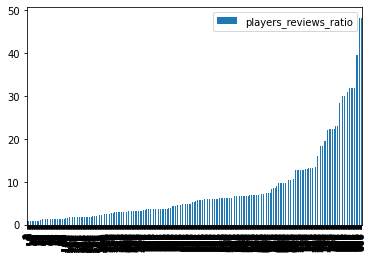

In [39]:
pd_df[['players_reviews_ratio']].sum

In [48]:
exclude = ["Free to Play", "Early Access", 'Utilities', 
            'Software Training', 'Education', 'Web Publishing']

pd_df \
    .loc[pd_df.genres.isin(exclude) == False] \
    [['players_reviews_ratio']].describe()

,players_reviews_ratio
count,763.000000
mean,8.618075
std,9.391445
min,0.798403
25%,2.989950
50%,5.724638
75%,10.532738
max,48.321839


In [124]:
dataset_path = os.path.join(os.path.dirname(os.path.realpath("")), "data/")

df = spark.read.parquet("file://" + dataset_path + "steam-dataset/steam_analysis.Games_Daily")

publishers = spark.sql(
    'select appid, title from parquet.`{}`'.format("file://" + dataset_path + "extracts/steam-dataset_games_28-12_5")
)

df = df \
    .join(publishers, on = 'appid') \
    .groupBy('appid') \
    .agg(F.size(F.collect_list('steamid')).alias('n_players')) \
    .join(publishers, on = "appid") \
    .sort(F.col('n_players').desc())

revsum_df = spark \
    .sql(
        """SELECT
        appid,
        total_reviews
        FROM parquet.`{}`""".format("file://" + dataset_path + "extracts/steam-reviews.parquet"))

genres_df = spark.sql(
    'select appid, Explode(genres) AS genres from parquet.`{}`'.format("file://" + dataset_path + "extracts/steam-dataset_games_28-12_5")
)

joined_df = genres_df.join(revsum_df, on = ['appid'])

# joined_df = joined_df \
#     .groupBy('appid') \
#     .agg(F.collect_set('total_reviews').alias('total_reviews')) \
#     .select('appid', F.explode('total_reviews').alias('total_reviews')) \
#     .join(genres_df, on = ['appid']) \
#     .join(df, on = ['appid'])

In [138]:
# revsum_df.describe().show()

# revsum_df \
#     .join(publishers, on = "appid") \
#     .sort(F.col('total_reviews').desc()) \
#     .show()


df = spark.read.parquet("file://" + dataset_path + "steam-dataset/steam_analysis.Games_Daily")
df = df \
    .join(publishers, on = 'appid') \
    .groupBy('appid') \
    .agg(F.size(F.collect_list('steamid')).alias('n_players')) \
    .join(publishers, on = "appid") \
    .join(revsum_df, on = 'appid') \
    .sort(F.col('n_players').desc())

df.show(truncate = False)

+------+---------+--------------------------------------------------+-------------+
|appid |n_players|title                                             |total_reviews|
+------+---------+--------------------------------------------------+-------------+
|8930  |591196   |Sid Meier's Civilization® V                       |63446        |
|225600|284866   |Blade Symphony                                    |1931         |
|8870  |232731   |BioShock Infinite                                 |35407        |
|304930|229233   |Unturned                                          |2961         |
|200710|211889   |Torchlight II                                     |14821        |
|24240 |196121   |PAYDAY™ The Heist                                 |7215         |
|20920 |194620   |The Witcher 2: Assassins of Kings Enhanced Edition|18325        |
|200260|188638   |Batman: Arkham City - Game of the Year Edition    |10419        |
|219640|162956   |Chivalry: Medieval Warfare                        |22166  

In [154]:
df.filter(F.col('title').contains("Banished")).show()

+------+---------+--------+-------------+
| appid|n_players|   title|total_reviews|
+------+---------+--------+-------------+
|242920|    63508|Banished|        20537|
+------+---------+--------+-------------+



In [69]:
joined_df \
    .describe() \
    .show()

joined_df \
    .filter(F.col('genres') == "Early Access") \
    .describe() \
    .show()

joined_df \
    .filter(F.col('genres') == "Adventure") \
    .describe() \
    .show()

count_df = joined_df \
    .groupby('genres') \
    .count()
count_df.show()

+-------+-----------------+-----------------+--------------+-----------------+
|summary|            appid|    total_reviews|        genres|        n_players|
+-------+-----------------+-----------------+--------------+-----------------+
|  count|             1255|             1255|          1255|             1255|
|   mean|222260.8207171315|2562.813545816733|          null|18053.09402390438|
| stddev|72176.84989198872|5407.391126020802|          null|38465.12477615768|
|    min|             1530|                0|        Action|                7|
|    max|           326840|            63446|Web Publishing|           591196|
+-------+-----------------+-----------------+--------------+-----------------+

+-------+-----------------+-----------------+------------+-----------------+
|summary|            appid|    total_reviews|      genres|        n_players|
+-------+-----------------+-----------------+------------+-----------------+
|  count|               80|               80|          80

<AxesSubplot:>

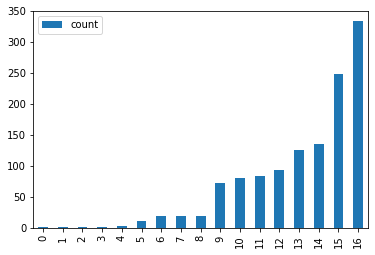

In [71]:
count_df \
    .sort(F.col('count')) \
    .toPandas() \
    .plot.bar()

<AxesSubplot:>

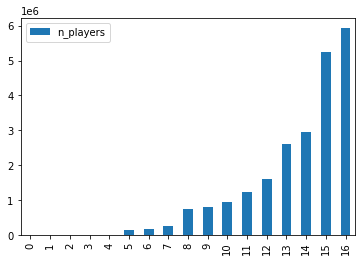

In [77]:
n_player_sum = joined_df \
    .groupby('genres') \
    .agg(F.sum('n_players').alias('n_players')) \
    .sort(F.col('n_players')) \
    .toPandas()

n_player_sum.plot.bar()

,genres,n_players
0,Animation & Modeling,299
1,Web Publishing,446
2,Education,745
3,Software Training,745
4,Utilities,13060
5,Sports,132684
6,Racing,161569
7,Massively Multiplayer,246223
8,Simulation,744742
9,Free to Play,814257


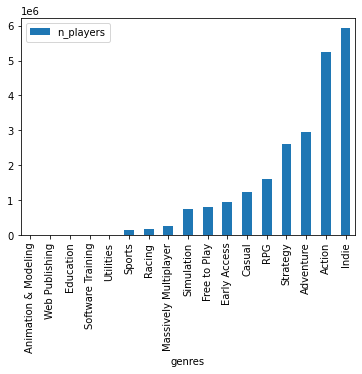

In [81]:
n_player_sum.plot.bar(x = "genres", y = "n_players")

n_player_sum

In [84]:
joined_df \
    .filter(F.col('genres') == "Indie") \
    .sort(F.col('appid')) \
    .show()

+-----+-------------+------+---------+
|appid|total_reviews|genres|n_players|
+-----+-------------+------+---------+
| 1530|          241| Indie|    36656|
| 4920|         4630| Indie|   131590|
|13000|           36| Indie|     2043|
|15400|           80| Indie|     4871|
|16500|            8| Indie|      401|
|16600|          146| Indie|    11737|
|17570|           53| Indie|    24817|
|18300|          222| Indie|     4058|
|18500|         2578| Indie|    54380|
|18600|           10| Indie|      709|
|18820|          172| Indie|     5956|
|19320|            3| Indie|      818|
|20820|          364| Indie|    37946|
|22000|         1730| Indie|    82039|
|22230|         1483| Indie|    30762|
|24420|          360| Indie|    31560|
|26800|         2673| Indie|   100180|
|33680|          706| Indie|     3695|
|35460|          447| Indie|    24000|
|41300|          469| Indie|    18403|
+-----+-------------+------+---------+
only showing top 20 rows



In [101]:
df = joined_df \
    .filter(F.col('genres').isin(exclude) == False) \
    .filter(F.col('n_players') > 1000) \
    .filter(F.col('total_reviews') > 10) \
    .withColumn('ratio', F.col('n_players') / F.col('total_reviews')) \
    .toPandas()

<AxesSubplot:>

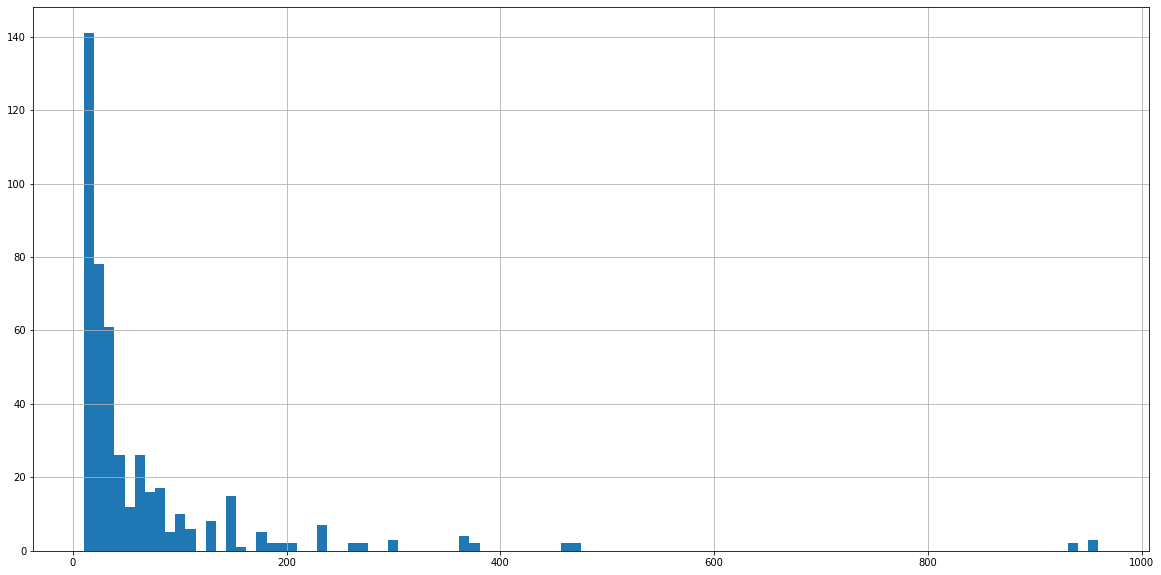

In [112]:
df.loc[df.ratio > df.ratio.quantile(0.5)].ratio.hist(bins = 100, figsize = (20 , 10))